# Notebook for testing the SDA model

In [2]:
import sys
sys.path.append('lib')
import AVHandler as avh
import AVPreprocess as avp
import numpy as np
import os
import pathlib
import librosa
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
from sklearn.model_selection import train_test_split

import tensorflow as tf

## import keras modules
from tensorflow.keras.layers import BatchNormalization,Dropout,Dense,Input,LeakyReLU
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.models import model_from_json
from tensorflow.keras import optimizers

In [3]:
# option
WAVE_PLOT = 1 # plot original wave, mixed wave
INVERSE_CHECK = 0 # check the inverse function of mel
DUMP = 0 # dump wave data to real wav
TRAIN_DENOISE = 1 # train the denoising model with mel freq input and output
DENOISE = 0 # use the pretrained denoise autoencoder

In [4]:
#Get data
#Training data
DATA_DIR = os.path.join(os.getcwd(), 'data')
print("DATA_DIR:", DATA_DIR, os.path.isdir(DATA_DIR))
TRAIN_DIR = os.path.join(DATA_DIR, "train")
print("TRAIN_DIR:", TRAIN_DIR, os.path.isdir(TRAIN_DIR))
TEST_DIR = os.path.join(DATA_DIR, "test")
print("TEST_DIR:", TEST_DIR, os.path.isdir(TEST_DIR))

DATA_DIR: d:\Code\External\SDA\data True
TRAIN_DIR: d:\Code\External\SDA\data\train True
TEST_DIR: d:\Code\External\SDA\data\test True


In [7]:
train_clean_path = os.path.join(TRAIN_DIR, "train_clean.wav")
train_clean_data, clean_sr = librosa.load(train_clean_path, sr=None)

train_noisy_path = os.path.join(TRAIN_DIR, "train_noisy.wav")
train_mix_data, mix_sr = librosa.load(train_noisy_path, sr=None)

test_clean_path = os.path.join(TEST_DIR, "test_clean.wav")
test_clean_data, clean_sr = librosa.load(test_clean_path, sr=None)

test_noisy_path = os.path.join(TEST_DIR, "test_noisy.wav")
test_mix_data, mix_sr = librosa.load(test_noisy_path, sr=None)

print(train_clean_data.shape, train_mix_data.shape)
print(test_clean_data.shape, test_mix_data.shape)

(29632000,) (29632000,)
(4640000,) (4640000,)


In [12]:
def wave_plot(clean_data, clean_sr, mix_data, mix_sr, clean_label="Clean wave", mix_label="Noisy wave"):
    
    # plot orignial wave
    size = clean_data.shape[0]
    time = np.arange(0,size)*(1.0 / clean_sr)
    plt.figure(1)
    plt.plot(time,clean_data)
    plt.xlabel("Time(s)")
    plt.ylabel("Amplitude")
    plt.title(clean_label)
    plt.grid(True)

    # plot mix wave
    size = mix_data.shape[0]
    time = np.arange(0,size)*(1.0 / mix_sr)
    plt.figure(2)
    plt.plot(time,mix_data)
    plt.xlabel("Time(s)")
    plt.ylabel("Amplitude")
    plt.title(mix_label)
    plt.grid(True)
    
    plt.show()
    
def mel_plot(clean_mel, mix_mel, clean_label="Clean", mix_label="Noisy"):
    
    plt.figure(1)
    plt.imshow(clean_mel.T, origin="bottomleft")
    #plt.xlabel("Time(s)")
    #plt.ylabel("Amplitude")
    #plt.title(clean_label)
    #plt.grid(True)

    # plot mix wave
    plt.figure(2)
    plt.imshow(mix_mel.T, origin="bottomleft")
    #plt.xlabel("Time(s)")
    #plt.ylabel("Amplitude")
    #plt.title(mix_label)
    #plt.grid(True)
    
    plt.show()


In [13]:
# fft windowing parameter #
fft_size = 1024
step_size = fft_size // 3 # distance to slide along the window

# fequency to mel parameter #
n_mels = 40 # number of mel frequency
start_freq = 0.0
end_freq = 8000.0

(86891, 80)
(86891, 80)


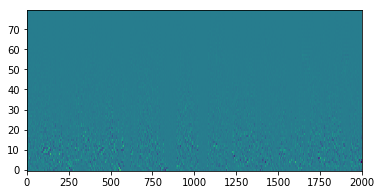

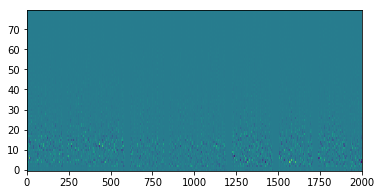

(13601, 80)
(13601, 80)


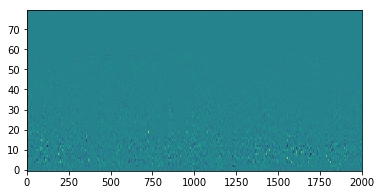

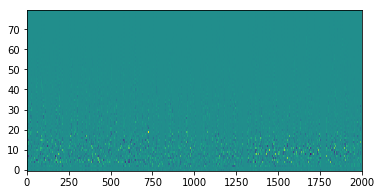

In [23]:
#Train data into mel form
sample = 2000

train_mel_mix_data = avp.time_to_mel(train_mix_data,mix_sr,fft_size,n_mels,step_size)
raw_x_train = avp.real_imag_expand(train_mel_mix_data)

print(raw_x_train.shape)

train_mel_clean_data = avp.time_to_mel(train_clean_data,clean_sr,fft_size,n_mels,step_size,fmax=8000)
raw_y_train = avp.real_imag_expand(train_mel_clean_data)

print(raw_y_train.shape)

mel_plot(raw_x_train[:sample], raw_y_train[:sample])

#Test data into mel form
test_mel_mix_data = avp.time_to_mel(test_mix_data,mix_sr,fft_size,n_mels,step_size)
raw_x_test = avp.real_imag_expand(test_mel_mix_data)

print(raw_x_test.shape)

test_mel_clean_data = avp.time_to_mel(test_clean_data,clean_sr,fft_size,n_mels,step_size,fmax=8000)
raw_y_test = avp.real_imag_expand(test_mel_clean_data)

print(raw_y_test.shape)

mel_plot(raw_x_test[:sample], raw_y_test[:sample])



G_max: 779004.7266525432
Train X min/max: 1e-07 1.0000001
Train y min/max: -0.9459646228014116 1.0


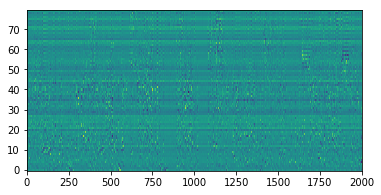

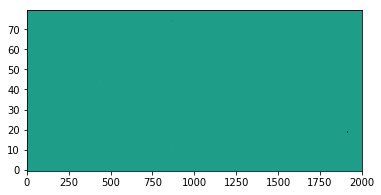

Test X min/max: 1e-07 1.0000001
Test y min/max: -0.3136412173921309 0.14200154526048203


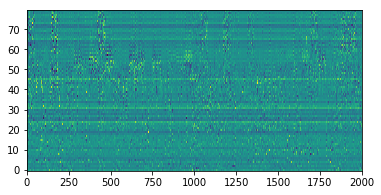

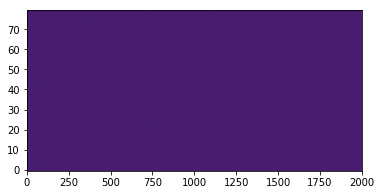

(73857, 80) (13034, 80) (73857, 80) (13034, 80)


In [24]:
# separate data to train test sets
D_X_train = avp.min_max_norm(raw_x_train) + 1e-7
D_y_train = raw_y_train / raw_x_train
G_max = np.max(D_y_train)

print("G_max:", G_max)

D_y_train = D_y_train/G_max

print("Train X min/max:", D_X_train.min(), D_X_train.max())
print("Train y min/max:", D_y_train.min(), D_y_train.max())

mel_plot(D_X_train[:sample], D_y_train[:sample])

X_test = avp.min_max_norm(raw_x_test) + 1e-7
y_test = raw_y_test / raw_x_test
y_test = y_test/G_max

print("Test X min/max:", X_test.min(), X_test.max())
print("Test y min/max:", y_test.min(), y_test.max())

mel_plot(X_test[:sample], y_test[:sample])

X_train, X_val, y_train, y_val = train_test_split(D_X_train, D_y_train, test_size=0.15, random_state=87)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

In [27]:
if TRAIN_DENOISE:
    n_input_dim = X_train.shape[1]
    n_output_dim = y_train.shape[1]

    n_hidden1 = 2049
    n_hidden2 = 500
    n_hidden3 = 180
    batch_norm_mom = 0.6
    dropout_frac = 0.1

    InputLayer1 = Input(shape=(n_input_dim,), name="InputLayer")
    InputLayer2 = BatchNormalization(axis=1, momentum=batch_norm_mom)(InputLayer1)

    HiddenLayer1_1 = Dense(n_hidden1, name="H1", activation='relu', kernel_initializer=he_normal(seed=27))(InputLayer2)
    HiddenLayer1_2 = BatchNormalization(axis=1, momentum=batch_norm_mom)(HiddenLayer1_1)
    HiddenLayer1_3 = Dropout(dropout_frac)(HiddenLayer1_2)

    HiddenLayer2_1 = Dense(n_hidden2, name="H2", activation='relu', kernel_initializer=he_normal(seed=42))(HiddenLayer1_3)
    HiddenLayer2_2 = BatchNormalization(axis=1, momentum=batch_norm_mom)(HiddenLayer2_1)

    HiddenLayer3_1 = Dense(n_hidden3, name="H3", activation='relu', kernel_initializer=he_normal(seed=65))(HiddenLayer2_2)
    HiddenLayer3_2 = BatchNormalization(axis=1, momentum=batch_norm_mom)(HiddenLayer3_1)

    HiddenLayer2__1 = Dense(n_hidden2, name="H2_R", activation='relu', kernel_initializer=he_normal(seed=42))(HiddenLayer3_2)
    HiddenLayer2__2 = BatchNormalization(axis=1, momentum=batch_norm_mom)(HiddenLayer2__1)

    HiddenLayer1__1 = Dense(n_hidden1, name="H1_R", activation='relu', kernel_initializer=he_normal(seed=27))(HiddenLayer2__2)
    HiddenLayer1__2 = BatchNormalization(axis=1, momentum=batch_norm_mom)(HiddenLayer1__1)
    HiddenLayer1__3 = Dropout(dropout_frac)(HiddenLayer1__2)

    OutputLayer = Dense(n_output_dim, name="OutputLayer", kernel_initializer=he_normal(seed=62))(HiddenLayer1__3)

    model = Model(inputs=[InputLayer1], outputs=[OutputLayer])
    opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0001, amsgrad=False)
    # loss = p_loss(OutputLayer,K.placeholder())
    model.compile(loss='mse', optimizer=opt)

    plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
    model.summary()

    tb_log_dir = os.path.join(os.getcwd(), 'logs')
    tensorboard = TensorBoard(log_dir=tb_log_dir, histogram_freq=0, write_graph=True, write_images=True)


Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      [(None, 80)]              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 80)                320       
_________________________________________________________________
H1 (Dense)                   (None, 2049)              165969    
_________________________________________________________________
batch_normalization_7 (Batch (None, 2049)              8196      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2049)              0         
_________________________________________________________________
H2 (Dense)                   (None, 500)               1025000   
_______________________________________

In [28]:
if TRAIN_DENOISE:
    # fit the model
    hist = model.fit(X_train, y_train, batch_size=512, epochs=100, verbose=1, validation_data=([X_val], [y_val]),
                     callbacks=[tensorboard])

    plt.figure(figsize=(10, 8))
    plt.plot(hist.history['loss'], label='Loss')
    plt.plot(hist.history['val_loss'], label='Val_Loss')
    plt.legend(loc='best')
    plt.title('Training Loss and Validation Loss')
    plt.show()

    results = model.evaluate(X_test, y_test, batch_size=len(y_test))
    print('Test loss:%3f' % results)

    # serialize model to JSON
    model_json = model.to_json()
    avh.mkdir('model')
    with open("model/model.json", 'w') as f:
        f.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model/model.h5")
    print("Saved model to disk")

Train on 73857 samples, validate on 13034 samples
Epoch 1/100
  512/73857 [..............................] - ETA: 7:01 - loss: 2.2174

W0812 15:59:32.162094 18952 callbacks.py:242] Method (on_train_batch_end) is slow compared to the batch update (0.388006). Check your callbacks.


73857/73857 [==============================] - 18s 245us/sample - loss: 0.2887 - val_loss: 0.0243
Epoch 2/100
73857/73857 [==============================] - 12s 162us/sample - loss: 0.1042 - val_loss: 0.0150
Epoch 3/100
73857/73857 [==============================] - 12s 167us/sample - loss: 0.0689 - val_loss: 0.0111
Epoch 4/100
73857/73857 [==============================] - 13s 171us/sample - loss: 0.0468 - val_loss: 0.0083
Epoch 5/100
73728/73857 [============================>.] - ETA: 0s - loss: 0.0317- ETA: 0s - loss: 0.0

KeyboardInterrupt: 